In [1]:
! pip install git+https://github.com/jglaser/paper_boltzmann_generators.git@tf2#subdirectory=software

  Cloning https://github.com/jglaser/paper_boltzmann_generators.git (to revision tf2) to /tmp/pip-req-build-2xiwahus
  Running command git clone -q https://github.com/jglaser/paper_boltzmann_generators.git /tmp/pip-req-build-2xiwahus
  Running command git checkout -b tf2 --track origin/tf2
  Switched to a new branch 'tf2'
  Branch 'tf2' set up to track remote branch 'tf2' from 'origin'.
  Created wheel for deep-boltzmann: filename=deep_boltzmann-0.1-cp37-none-any.whl size=40082 sha256=745d8a4677193f0ade62de1571025b13da2b51766c81b763c0485fa290770374
  Stored in directory: /tmp/pip-ephem-wheel-cache-rs_vivdt/wheels/42/9f/f7/e2dcd8deb7caf454aae09d183c79d4112768020758493c87de
Successfully built deep-boltzmann


In [1]:
import deep_boltzmann

In [2]:
import matplotlib.pyplot as plt
def plot_config(pts,L=1,title=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    circles = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts]
    for c in circles:
        ax.add_patch(c)
    ax.set_xlim(-L/2,L/2)
    ax.set_ylim(-L/2,L/2)
    if title is not None:
        ax.set_title(title)

def plot_config_wrap(pts,L=1,title=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    pts_addl = []
    for p in pts:
        if p[0] < -L/2+0.5:
            pts_addl.append([p[0]+L, p[1]])  
            if p[1] < -L/2+0.5:
                pts_addl.append([p[0]+L, p[1]+L])
            if p[1] > -L/2+0.5:
                pts_addl.append([p[0]+L, p[1]-L])
        if p[0] > -L/2+0.5:
            pts_addl.append([p[0]-L, p[1]])
            if p[1] < -L/2+0.5:
                pts_addl.append([p[0]-L, p[1]+L])
            if p[1] > -L/2+0.5:
                pts_addl.append([p[0]-L, p[1]-L])
        if p[1] < -L/2+0.5:
            pts_addl.append([p[0], p[1]+L])
        if p[1] > -L/2+0.5:
            pts_addl.append([p[0], p[1]-L])
        
    circles = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts]
    circles2 = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts_addl]
    for c in circles:
        ax.add_patch(c)
    for c in circles2:
        ax.add_patch(c)
    ax.set_xlim(-L/2,L/2)
    ax.set_ylim(-L/2,L/2)
    if title is not None:
        ax.set_title(title)

### Invertible network for hard particles

In [3]:
# Maximum likelihood in z
import tensorflow as tf
def loss_z(inv_net):
    return -inv_net.log_likelihood_z_normal()

In [4]:
import tensorflow as tf
def loss_x(inv_net):
    x = inv_net.output_x
    f = inv_net.overlap_model.smooth_overlap_tf(x)
    #return tf.where(f>tf.zeros_like(f),tf.math.log(f)-inv_net.log_det_Jzx[:,0],0.0)
    #return f*tf.math.exp(-inv_net.log_det_Jzx[:,0])
    return f-inv_net.log_det_Jzx[:,0]
    

In [5]:

import tensorflow.keras as keras
import tensorflow as tf
from deep_boltzmann.networks.invertible import InvNet

class OverlapInvNet(InvNet):

    def __init__(self, overlap_model, layers):
        """ Invertible net where we have an overlap function (==0 or 1) that defines p(x)
            and the prior is the uniform on the interval [a,b)"""
        self.overlap_model = overlap_model
        super().__init__(overlap_model.dim, layers, prior='normal')
        
        self.Tzx.add_loss(loss_x(self))
        self.Txz.add_loss(loss_z(self))
        
    @classmethod
    def load(cls, filename, energy_model):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        keras.backend.clear_session()
        D = load_obj(filename)
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return EnergyInvNet(energy_model, layers, prior=prior)

    def weight(self):
        """ Computes the reweighting factor
        """
        z = self.input_z
        x = self.output_x
        # compute overlap property
        f = self.overlap_model.overlap_tf(x)
        weight = tf.math.exp(self.log_det_Jzx[:, 0])
        return weight

    def sample(self, nsample=100000):
        """ Samples from prior distribution in z and produces generated x configurations

        Parameters:
        -----------
        temperature : float
            Relative temperature. Equal to the variance of the isotropic Gaussian sampled in z-space.
        nsample : int
            Number of samples

        Returns:
        --------
        sample_z : array
            Samples in z-space
        sample_x : array
            Samples in x-space
        weight_z:
            Weight of z samples
        overlap_x : array
            Overlap property of x samples
        w : array
            Weight of samples

        """
        sample_z, energy_z = self.sample_z(nsample=nsample, return_energy=True)
        sample_x, Jzx = self.transform_zxJ(sample_z)
        overlap_x = self.overlap_model.overlap(sample_x)
        w = np.exp(Jzx)

        return sample_z, sample_x, np.exp(-energy_z), overlap_x, w

    
    def train_z(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
                
        self.Txz.compile(optimizer)

        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None

        hist = self.Txz.fit(x=x, validation_data=validation_data,
                            batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist
    
    def train_x(self, optimizer=None, lr=0.001, batches=1,epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
                
        self.Tzx.compile(optimizer)

        x = self.sample_z(nsample=batches*batch_size, return_energy=False)
        hist = self.Tzx.fit(x=x,batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist

    def train_both(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
       
        inputs = []
        outputs = []
        losses = []
        losses.append(loss_z(self))
        losses.append(loss_x(self))
        inputs.append(self.input_x)
        inputs.append(self.input_z)
        outputs.append(self.output_z)
        outputs.append(self.output_x)

        self.model = keras.models.Model(inputs=inputs, outputs=outputs)
        l = losses[0]+losses[1]
        self.model.add_loss(l)
        self.model.compile(optimizer=optimizer)
        
        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None

        w = self.sample_z(nsample=x.shape[0], return_energy=False)
        hist = self.model.fit(x=[x,w], validation_data=validation_data,
                            batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist

In [6]:
class Limit(object):
    def __init__(self, dim, L=1):
        self.L = L
        self.dim = dim
    
        self.tanh = tf.keras.layers.Activation('tanh')
        self.scale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=self.L/2)
        self.inv_scale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=2/self.L)
        self.atanh = tf.keras.layers.Activation(lambda x: tf.atanh(x))
        
    def connect_xz(self, x):
        def lambda_Jxz(x):
            J = -tf.math.log(1-(2*x/self.L)**2)
            return tf.reduce_sum(J,axis=-1)[0] * tf.ones((tf.shape(x)[0], 1))
        self.log_det_xz = keras.layers.Lambda(lambda_Jxz)(x)
        z = self.atanh(self.inv_scale(x))
        return z

    def connect_zx(self, z):
        def lambda_Jzx(z):
            J = -tf.math.log(tf.cosh(z)**2)
            return tf.reduce_sum(J,axis=-1)[0] * tf.ones((tf.shape(z)[0], 1))
        self.log_det_zx = keras.layers.Lambda(lambda_Jzx)(z)
        x = self.scale(self.tanh(z))
        return x

    @property
    def log_det_Jxz(self):
        """ Log of |det(dz/dx)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_xz

    @property
    def log_det_Jzx(self):
        """ Log of |det(dx/dz)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_zx


In [7]:
from deep_boltzmann.networks.invertible import split_merge_indices, SplitChannels, MergeChannels, \
                                               RealNVP, NICER, InvNet, nonlinear_transform, Scaling

def invnet(dim, layer_types, overlap_model=None, channels=None, L=1.0,
           nl_layers=2, nl_hidden=100, nl_activation='relu',
           nl_activation_t='relu',scale=None, prior='normal'):
    """
    layer_types : str
        String describing the sequence of layers. Usage:
            N NICER layer
            R RealNVP layerl
            S Scaling layer
        Splitting and merging layers will be added automatically
    overlap_model : Overlap model class
        Class with overlap_tf() and dim
    channels : array or None
        Assignment of dimensions to channels (0/1 array of length ndim)
    nl_layers : int
        Number of hidden layers in the nonlinear transformations
    nl_hidden : int
        Number of hidden units in each nonlinear layer
    nl_activation : str
        Activation functions used in the nonlinear layers
    scale : None or float
        If a scaling layer is used, fix the scale to this number. If None, scaling layers are trainable
    """
    # fix channels
    channels, indices_split, indices_merge = split_merge_indices(dim, nchannels=2, channels=channels)

    # augment layer types with split and merge layers
    split = False
    tmp = ''
    for ltype in layer_types:
        if (ltype == 'S' or ltype == 'L') and split:
            tmp += '>'
            split = False
        if (ltype == 'N' or ltype == 'R') and not split:
            tmp += '<'
            split = True
        tmp += ltype
    if split:
        tmp += '>'
    layer_types = tmp
    print(layer_types)

    # prepare layers
    layers = []

    #reg = tf.keras.regularizers.l2(.1) #?
    reg = None
    for ltype in layer_types:
        if ltype == '<':
            # split into two x channels
            layers.append(SplitChannels(dim, nchannels=2, channels=channels))
        if ltype == '>':
            # merge into one z channel
            layers.append(MergeChannels(dim, nchannels=2, channels=channels))
        if ltype == 'N':
            M1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation)
            M2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation)
            layers.append(NICER([M1, M2]))
        elif ltype == 'R':
            S1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, init_outputs=0,
                                     activity_regularizer=reg)
            T1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation_t)
            S2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, init_outputs=0,
                                     activity_regularizer=reg)
            T2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation_t)
            layers.append(RealNVP([S1, T1, S2, T2]))
        elif ltype == 'L':
            layers.append(Limit(dim, L=L))
        elif ltype == 'S':
            # scaling layer
            if scale is None:
                scaling_factors = None
            else:
                scaling_factors = scale * np.ones((1, dim))
            layers.append(Scaling(dim, scaling_factors=scaling_factors, trainable=(scale is None)))

    if overlap_model is None:
        inv_net = InvNet(dim, layers, prior='normal')
    else:
        inv_net = OverlapInvNet(overlap_model, layers)
    
    inv_net.reg = reg
    return inv_net

### Hard disk overlap

In [8]:
import numpy as np

def ensure_traj(X):
    if np.ndim(X) == 2:
        return X
    if np.ndim(X) == 1:
        return np.array([X])
    raise ValueError('Incompatible array with shape: ', np.shape(X))

    
def dist2_min_image(crd1, crd2, L, dim=2):
    """ Returns the distance matrix or matrices between particles, with periodic boundary conditions

    Parameters
    ----------
    crd1 : array or matrix
        first coordinate set
    crd2 : array or matrix
        second coordinate set
    L: length of simulation box
    dim : int
        dimension of particle system. If d=2, coordinate vectors are [x1, y1, x2, y2, ...]

    """
    crd1 = ensure_traj(crd1)
    crd2 = ensure_traj(crd2)
    n = int(np.shape(crd1)[1]/dim)

    crd1_components = [np.tile(np.expand_dims(crd1[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    crd2_components = [np.tile(np.expand_dims(crd2[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    
    dr_components = np.array([(crd1_components[i] - np.transpose(crd2_components[i], axes=(0, 2, 1))) for i in range(dim)])
    
    # minimum image
    D2_components = dr_components - L*((dr_components+0.5*L)//L)
    D2_components = D2_components**2
    D2 = np.sum(D2_components, axis=0)
    return D2

class HardDisks(object):
    def __init__(self,N, L,sigma,eps=1):
        """ N: number of particles
            L: Box length
            sigma: Particle size"""
        self.N = N
        self.dim = 2*self.N # dim = 2
        self.L = L
        self.sigma = sigma
        self.mask_matrix = np.ones((self.N, self.N), dtype=np.float32)
        for i in range(self.N):
            self.mask_matrix[i, i] = 0.0
        self.eps=eps

    def wrap(self, x):
        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]        
        xcomp -= ((xcomp+0.5*self.L)//self.L)*self.L
        ycomp -= ((ycomp+0.5*self.L)//self.L)*self.L
        out = np.zeros(shape=x.shape)
        out[:,0::2] = xcomp
        out[:,1::2] = ycomp
        return out
    
    def overlap(self, x):
        # all pairwise distances
        batchsize = np.shape(x)[0]
        D2 = dist2_min_image(x, x, self.L)
        mmatrix = np.tile(np.expand_dims(self.mask_matrix, 0), (batchsize, 1, 1))
        
        # overlap
        f = np.max(mmatrix*np.where(D2<self.sigma*self.sigma,1.0,0.0), axis=(1, 2))
        return f
    

    @tf.custom_gradient
    def tf_min_image(self,Dx):
        res = Dx-tf.math.floordiv(Dx+0.5*self.L,self.L)*self.L
        return res, lambda upstream: upstream

    def overlap_tf(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])

        # minimum image
        layer_min_image = tf.keras.layers.Lambda(lambda x: self.tf_min_image(x))
        Dx = layer_min_image(Dx) 
        Dy = layer_min_image(Dy) 
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        return tf.reduce_max(tf.where((D2<self.sigma*self.sigma),
                                      mmatrix*tf.ones_like(D2),tf.zeros_like(D2)),
                             axis=(1, 2))
    
    def smooth_overlap_tf(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        # minimum image
        layer_min_image = tf.keras.layers.Lambda(lambda x: self.tf_min_image(x))
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])
        Dx = layer_min_image(Dx) 
        Dy = layer_min_image(Dy) 
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])
        # return tf.reduce_sum(self.eps*tf.nn.relu(mmatrix*(self.sigma-tf.math.sqrt(D2))), axis=(1, 2))
        return tf.reduce_sum(self.eps*tf.keras.activations.relu(mmatrix*(self.sigma-tf.math.sqrt(D2))), axis=(1, 2))

        # res = None
        # for i in range(-1,2):
        #     for j in range(-1,2):

        #       Dx = Xcomp - tf.transpose(Xcomp+i*self.L, perm=[0, 2, 1])
        #       Dy = Ycomp - tf.transpose(Ycomp+j*self.L, perm=[0, 2, 1])
        #       D2 = Dx**2 + Dy**2

        #       o = tf.reduce_sum(self.eps*tf.nn.relu(mmatrix*(self.sigma-tf.math.sqrt(D2))), axis=(1, 2))
        #       if res == None:
        #           res = o
        #       else:
        #           res += o
        # return res
    def smooth_overlap_tf_actual(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        # minimum image
        layer_min_image = tf.keras.layers.Lambda(lambda x: self.tf_min_image(x))
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])
        Dx = layer_min_image(Dx) 
        Dy = layer_min_image(Dy) 
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])
        return tf.reduce_sum(self.eps*tf.nn.relu(mmatrix*(self.sigma-tf.math.sqrt(D2))), axis=(1, 2))

In [9]:
tf.keras.activations.relu([0.0, 0.05],threshold=-0.05)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.  , 0.05], dtype=float32)>

### Create the model

In [10]:
phi = 0.3 # packing fraction
N = 64
sigma = 1
L = (N*(np.pi*0.25*sigma**2)/phi)**0.5

In [11]:
model = HardDisks(N=N,
                  L=L,
                  sigma=sigma,
                  eps=5000)

In [12]:
batchsize = 4096

### Train with the linear combination of two loss functions

In [13]:
def act(x):
    return -tf.keras.layers.ReLU()(x)
    #return -tf.math.sigmoid(x)

In [14]:
# reset model
#bg = invnet(model.dim, 'RRRRRRRR', overlap_model=model, nl_layers=4, nl_hidden=200, #100
# bg = invnet(model.dim, 'LRRRRRRRRRRRR', overlap_model=model, nl_layers=4, nl_hidden=200, #100
bg = invnet(model.dim, 'LRRRRRRRRRRRR', overlap_model=model, nl_layers=4, nl_hidden=200, #100
#bg = invnet(model.dim, 'LNNNNNNNN', overlap_model=model, nl_layers=4, nl_hidden=200, #100
           nl_activation='tanh', nl_activation_t='relu',L=L)
        #    nl_activation='relu', nl_activation_t='tanh',L=L)

L<RRRRRRRRRRRR>


In [15]:
#hist_bg = bg.train_z(x=Xtrain,epochs=3,lr=0.0001,batch_size=batchsize)

In [ ]:
hist_bg = bg.train_x(batches=500,epochs=50,lr=0.0001,batch_size=batchsize)

Epoch 1/50
423/500 [========================>.....] - ETA: 6s - loss: 105205.2068

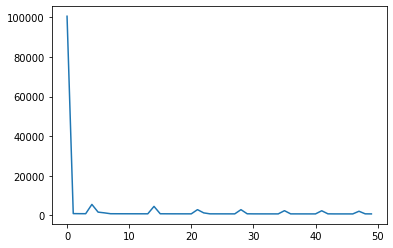

In [66]:
fig, ax = plt.subplots()
ax.plot(hist_bg.history['loss'])

In [48]:
print(tf.__version__)

2.4.1


In [67]:
_, sample_x, _, overlap_x, w = bg.sample(nsample=100)

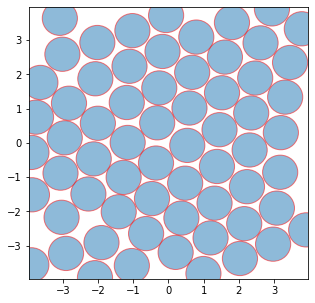

In [68]:
plot_config(model.wrap(bg.Tzx.predict(np.zeros_like(sample_x[0:1]))).reshape(-1,2),L=L)

In [69]:
model.wrap(bg.Tzx.predict(np.zeros_like(sample_x[0:1]))).reshape(-1,2)

array([[ 3.78884387,  3.32770371],
       [-3.06660628, -0.88135248],
       [-2.27419472, -1.48941875],
       [-1.10643125,  2.2343812 ],
       [-0.63490295, -2.64413714],
       [ 1.45117188,  0.38469917],
       [ 0.59726053,  1.01698399],
       [-1.1583184 ,  0.01269646],
       [-1.18387461,  1.17826867],
       [ 3.45545006,  2.34494281],
       [ 3.08158684, -1.90196693],
       [ 2.23100305, -1.27676809],
       [-3.76260495,  0.7506544 ],
       [-0.06666134,  3.71561813],
       [-3.63774037,  1.7627635 ],
       [-2.90964365, -3.2227118 ],
       [ 0.20456131, -3.19228864],
       [ 0.36757398, -2.19227672],
       [-0.35364953, -0.58762223],
       [-3.89499521, -3.55572295],
       [-3.89226151, -0.27720004],
       [-3.01324272,  2.58554554],
       [-1.41274858, -2.00848293],
       [ 2.15301752, -2.35537076],
       [-2.01989126,  2.9272244 ],
       [-3.87876391, -1.51372778],
       [ 3.91291928, -2.53668523],
       [ 2.35090828,  0.8729977 ],
       [-2.00540423,

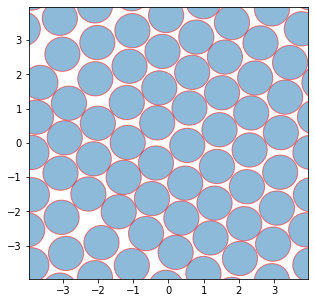

In [70]:
plot_config_wrap(model.wrap(bg.Tzx.predict(np.zeros_like(sample_x[0:1]))).reshape(-1,2),L=L)

In [71]:
model.smooth_overlap_tf(np.ones((1,128),dtype=np.float32)).numpy()

array([20160000.], dtype=float32)

In [72]:
model.smooth_overlap_tf_actual(sample_x).numpy()

array([  0.       ,   0.       ,   0.       ,   0.       ,  51.198605 ,
        30.64573  ,   0.       ,   0.       ,   8.371472 ,   0.       ,
         0.       ,  16.511082 ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       , 107.76341  ,  28.996468 ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,  55.710075 ,   0.       ,   0.8404255,  28.176903 ,
         5.56767  ,   1.0424852,   0.       ,  37.792923 ,   0.       ,
         0.       ,   3.0434132,   0.       ,   0.       ,   0.       ,
         0.       ,  45.53199  ,   9.931922 ,   0.       ,   0.       ,
         3.771782 ,   0.       ,   0.       ,   0.       ,   0.       ,
        13.65602  ,   0.       ,   1.4275312,   0.       ,   0.       ,
        61.45835  ,   0.       ,   2.796054 ,   0.       ,   0.       ,
         0.       ,   0.       ,  31.123756 ,   0.       ,   0. 

In [73]:
np.sum(model.smooth_overlap_tf_actual(sample_x).numpy() == 0) / len(model.smooth_overlap_tf_actual(sample_x).numpy())

0.68

In [74]:
s_test = sample_x[0:1].reshape(-1,2)

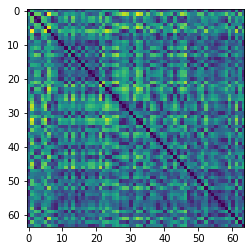

In [57]:
plt.imshow(np.sqrt(((s_test[:,:,None] - s_test[:,:,None].T)**2).sum(1)))

In [29]:
L/2

3.963327297606011

In [75]:
dist_mtx = [np.sqrt(((sample_x[i:i+1].reshape(-1,2)[:,:,None] - sample_x[i:i+1].reshape(-1,2)[:,:,None].T)**2).sum(1)) for i in range(100)]

In [76]:
[np.min(mtx[mtx > 0]) for mtx in dist_mtx]

[1.0015265,
 1.0032399,
 1.0014725,
 1.0013084,
 0.99600476,
 0.9969354,
 1.0006622,
 1.001,
 0.99916285,
 1.002228,
 1.0013214,
 0.9983489,
 1.0018969,
 1.0025005,
 1.0025374,
 1.0006756,
 1.0018066,
 0.9909114,
 0.99710035,
 1.0030913,
 1.0031811,
 1.0039049,
 1.005068,
 1.0012507,
 1.0021875,
 1.0045216,
 1.0017639,
 1.0010232,
 1.0008172,
 1.0018218,
 1.0007296,
 0.9991744,
 1.0046905,
 1.0060854,
 0.9971823,
 0.99944323,
 0.99989575,
 1.0003722,
 0.99622077,
 1.004909,
 1.0002708,
 1.0021056,
 1.0042803,
 1.0022063,
 1.0012975,
 1.000511,
 0.9954468,
 1.0009786,
 1.0036517,
 1.0015423,
 0.99967176,
 1.0050495,
 1.0017658,
 1.0004,
 1.0010854,
 1.0035062,
 1.0011758,
 0.9998572,
 1.0006402,
 1.0020189,
 0.99385417,
 1.003601,
 0.99972045,
 1.0021633,
 1.0036601,
 1.0018245,
 1.0029228,
 1.0006564,
 1.001082,
 1.0000446,
 1.0020964,
 1.001788,
 1.0000186,
 1.0027021,
 1.0014807,
 1.0026114,
 1.0019759,
 0.99771327,
 0.9988963,
 0.99927646,
 1.0041413,
 1.0023237,
 0.99952894,
 1.002

In [77]:
phi = 0.8 # packing fraction
N = 2
sigma = 1
L = (N*(np.pi*0.25*sigma**2)/phi)**0.5

In [62]:
model2 = HardDisks(N=2,
                   L=10,
                   sigma=sigma,
                   eps=100)

In [65]:
model2.smooth_overlap_tf(np.array([[0.0, 0.0, 0.0, 1.1]])).numpy()

array([0.], dtype=float32)

In [23]:
sample_x.min(), sample_x.max()

(-3.9571977, 3.9597595)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


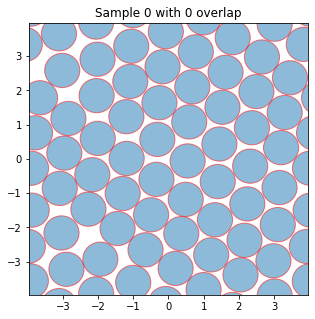

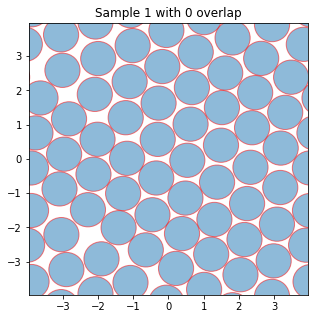

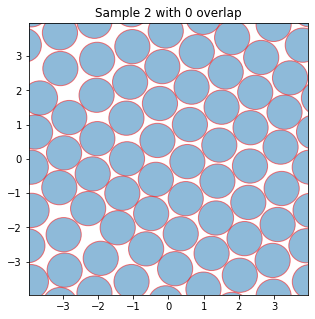

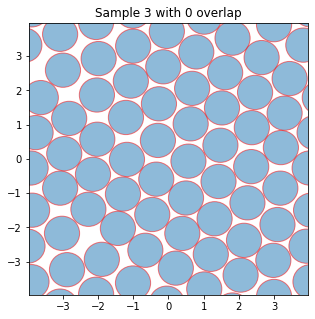

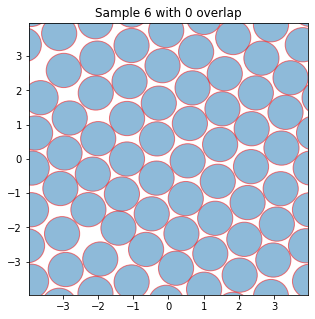

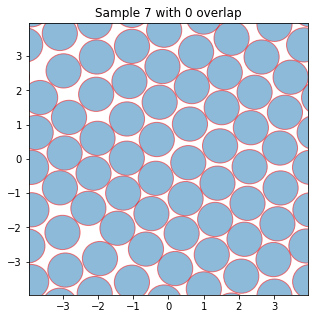

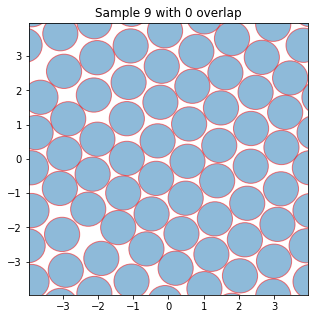

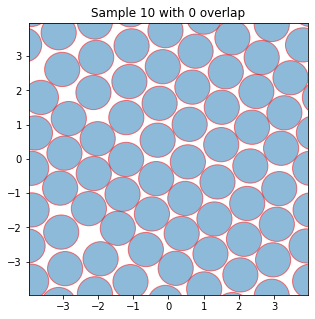

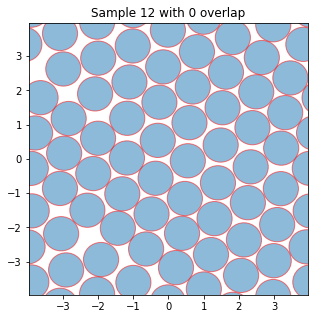

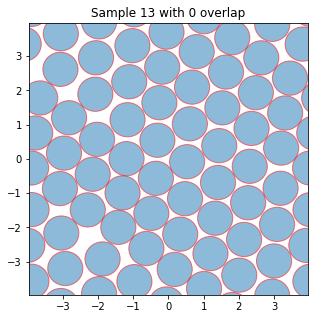

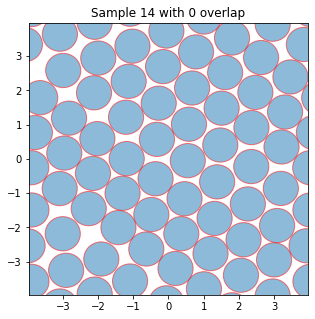

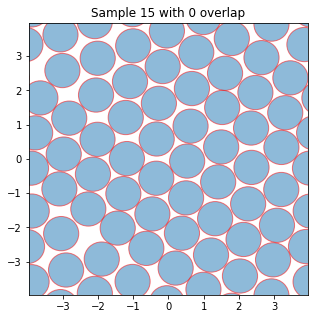

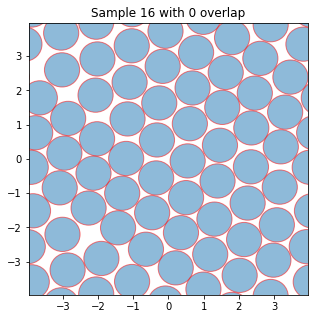

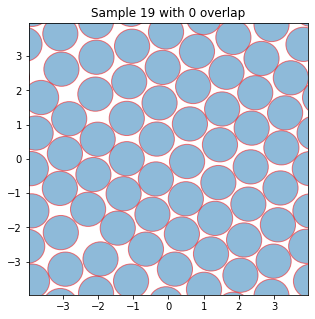

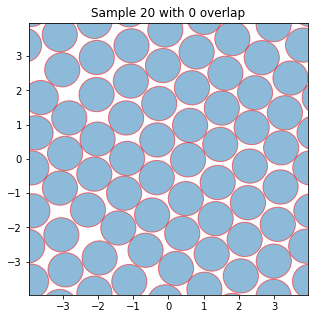

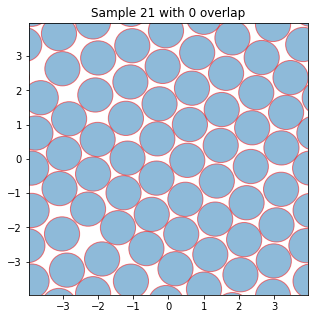

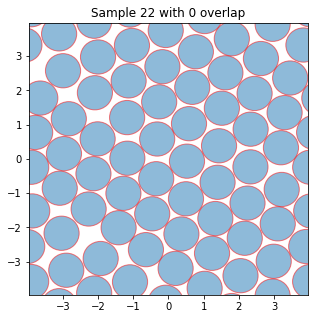

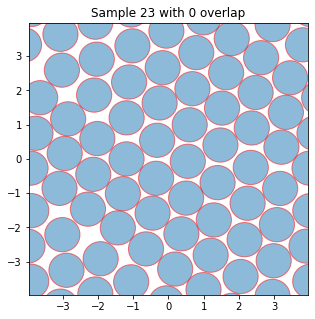

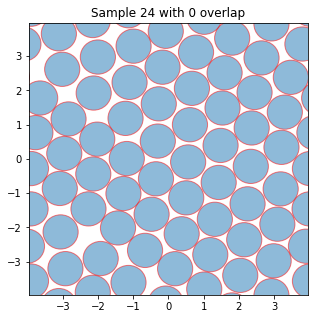

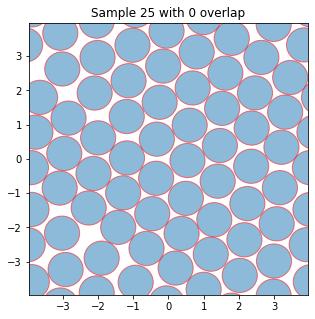

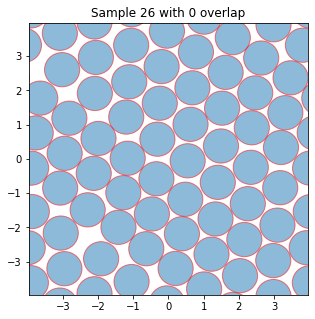

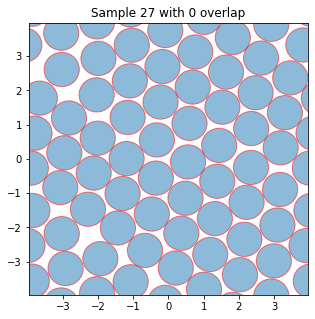

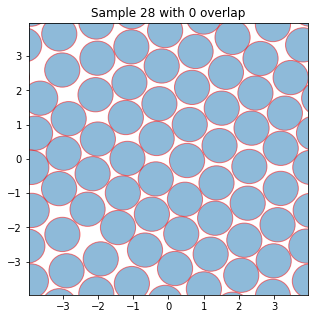

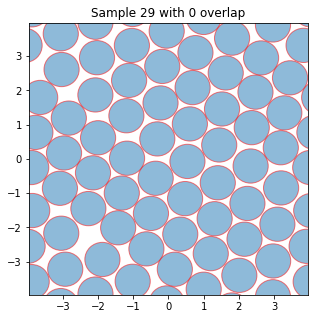

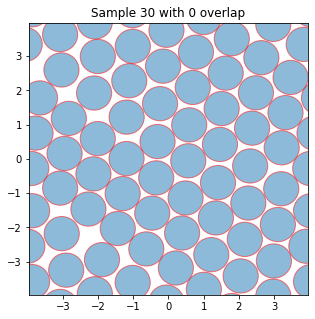

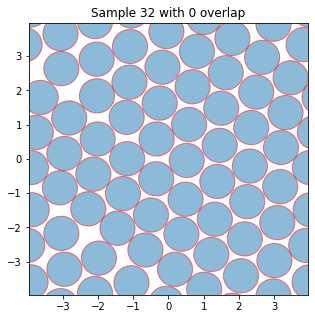

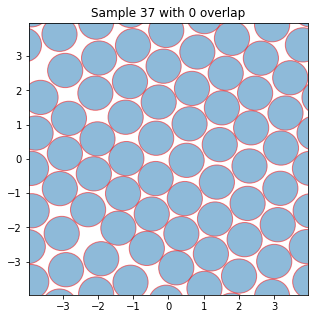

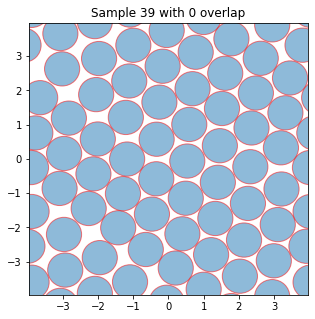

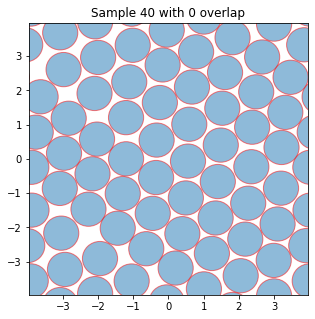

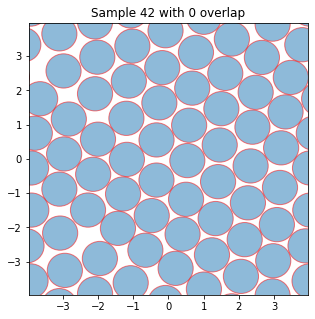

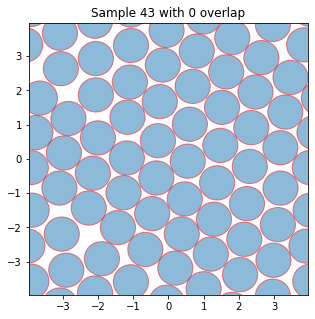

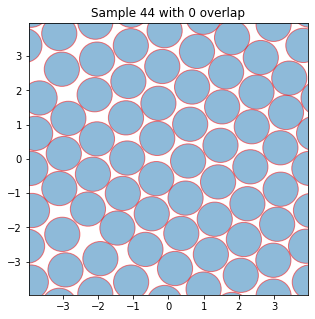

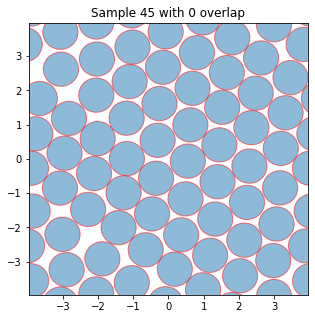

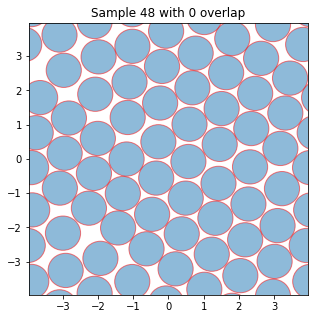

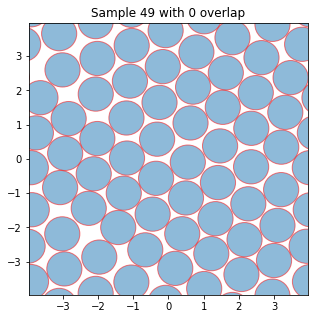

In [79]:
for i in range(50):
    if model.smooth_overlap_tf(sample_x[i:i+1]) == 0:
        plot_config_wrap(model.wrap(sample_x)[i:i+1].reshape(-1,2),L=L,title=f'Sample {i} with 0 overlap')

In [36]:
_, sample_x, _, overlap_x, w = bg.sample(nsample=100)

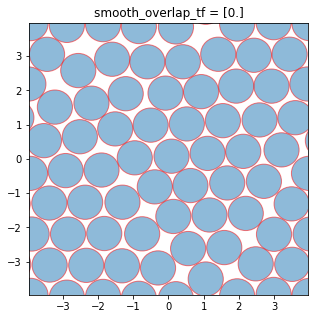

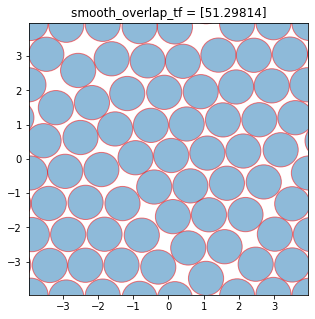

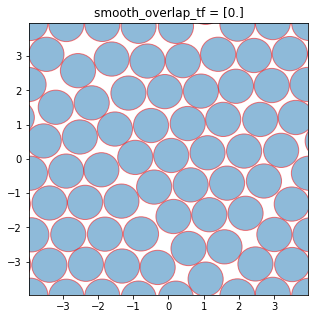

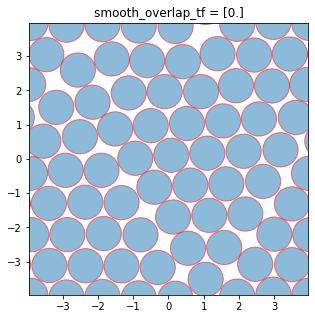

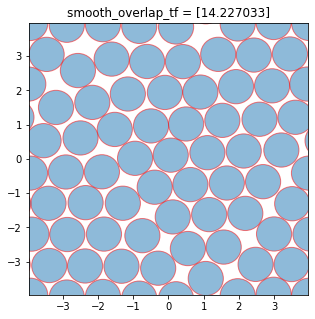

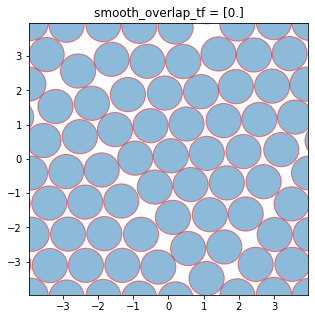

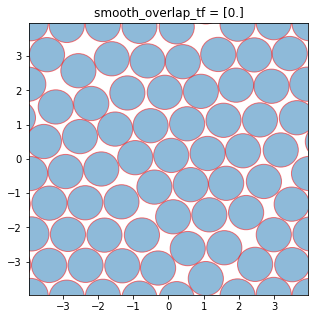

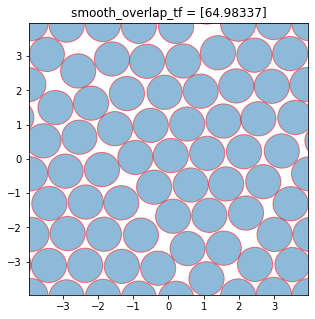

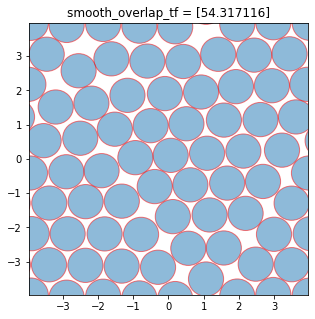

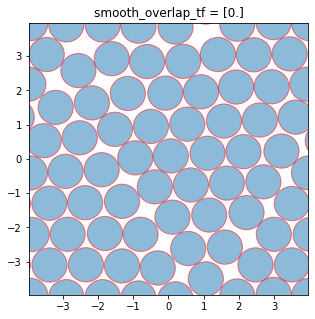

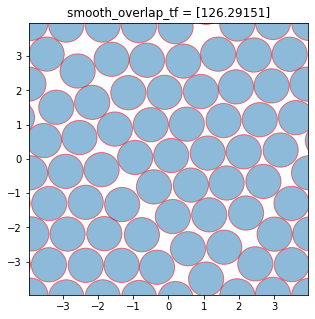

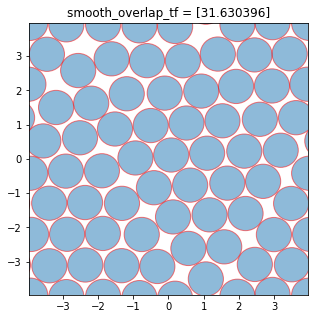

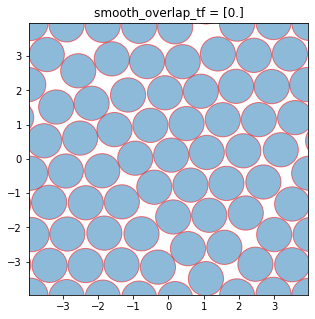

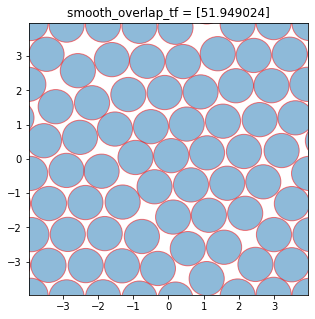

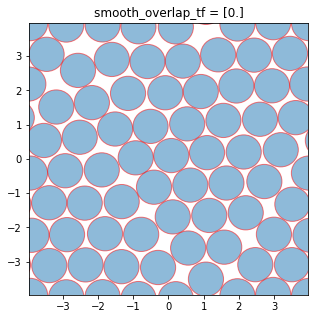

In [62]:
for i in range(15):
  plot_config_wrap(model.wrap(sample_x)[i:i+1].reshape(-1,2),L=L,title=f'smooth_overlap_tf = {model.smooth_overlap_tf(sample_x[i:i+1]).numpy()}')

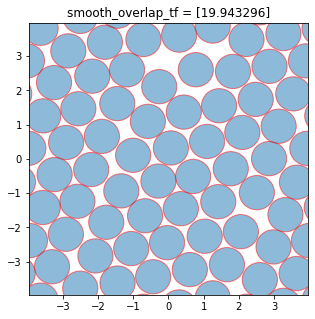

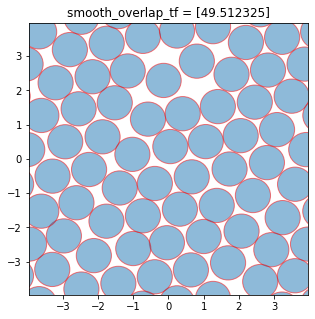

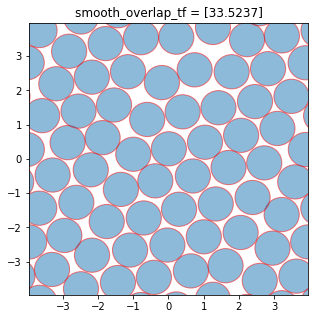

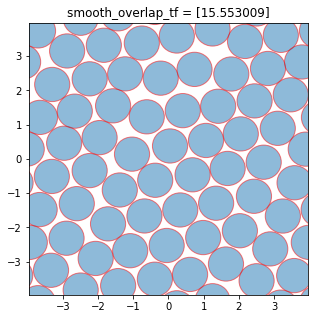

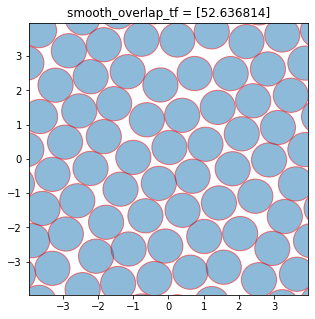

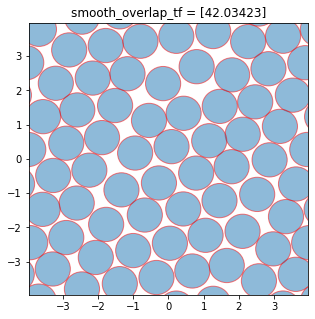

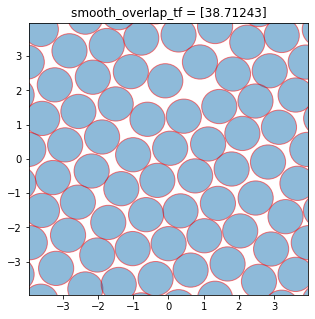

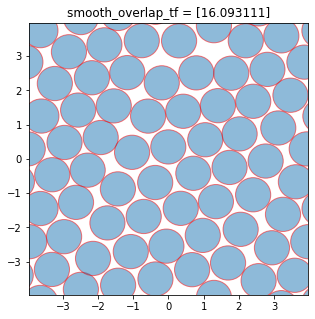

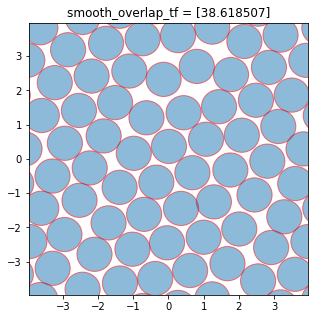

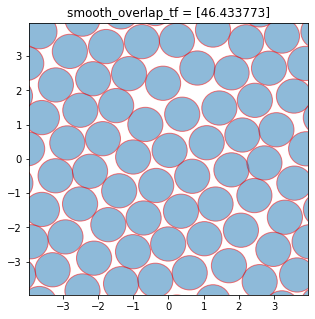

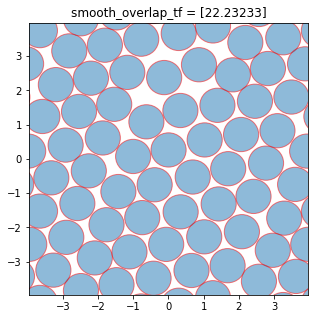

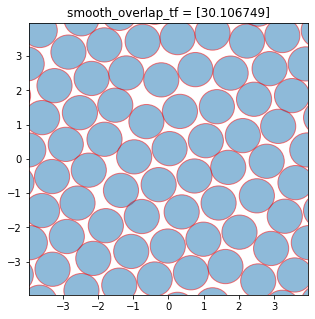

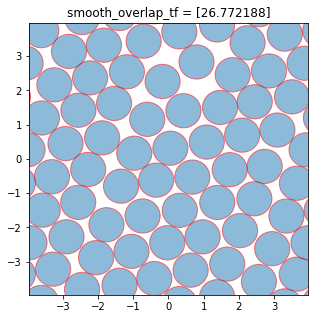

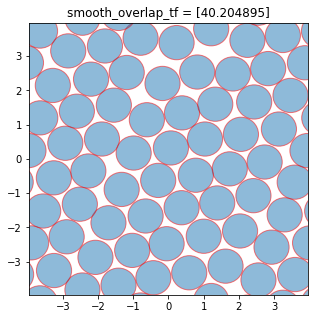

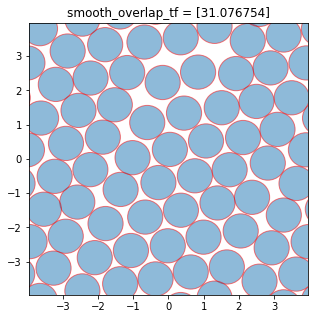

In [38]:
for i in range(15):
  plot_config_wrap(model.wrap(sample_x)[i:i+1].reshape(-1,2),L=L,title=f'smooth_overlap_tf = {model.smooth_overlap_tf(sample_x[i:i+1]).numpy()}')

In [39]:
model.smooth_overlap_tf(sample_x[0:1]).numpy()

array([19.943296], dtype=float32)

(array([76.,  4.,  6.,  4.,  4.,  3.,  0.,  1.,  1.,  1.]),
 array([  0.      ,  14.572919,  29.145838,  43.718758,  58.291676,
         72.86459 ,  87.437515, 102.01043 , 116.58335 , 131.15627 ,
        145.72919 ], dtype=float32),
 <a list of 10 Patch objects>)

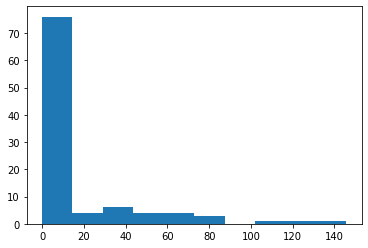

In [61]:
fig, ax = plt.subplots()
ax.hist(model.smooth_overlap_tf(sample_x))

In [26]:
tf.keras.backend.eval(tf.reduce_mean(w))

0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

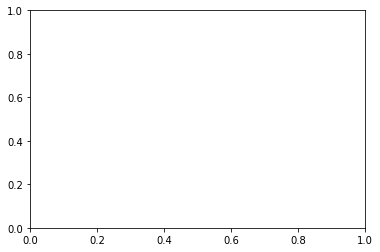

In [27]:
fig, ax = plt.subplots()
ax.hist(tf.keras.backend.eval(model.smooth_overlap_tf(sample_x)*w/tf.reduce_mean(w)),bins=20)
ax.set_yscale('log')

NameError: ignored

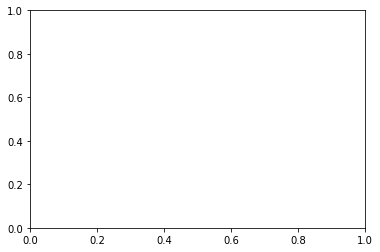

In [ ]:
fig, ax = plt.subplots()
ax.hist(tf.keras.backend.eval(model.smooth_overlap_tf(Xtrain[0:1000])),bins=20)